## Final Report: Enzyme vs. Non-Enzyme Classification

Remmy Chen<br>
Computational Systems Biology<br>
4/25/2019

## Introduction

Thanks to the advancement of sequencing technologies and the good work of the scientific community, there is now an abundance of data collected and hosted online that allows computational analyses and research to be carried out. KEGG (Kyoto Encyclopedia of Genes and Genomes) is one such collection of databases that is utilized for biochemical research, containing information related to genomes, biological pathways, diseases, drugs, and chemical substances. Despite the abundance of data in the post-genome era, there are still many open problems in bioinformatics. An example is the prediction and classification of proteins given only their primary amino acid (AA) sequence. Currently, the primary way of determining whether an AA sequence that has never been seen before is enzymatic or not is to perform laboratory research and investigation on it. In place of this time- and resource-consuming process, the goal of this project is to predict enzymes and non-enzymes using machine learning approaches based on AA sequence information.

## Problem definition

In research, once data becomes abundant, the question of how one should organize and interpret these data arises. Computer science offers useful tools for data organization and meaning derivation. To demonstrate, this project will explore a binary classification question using data that is publicly available from the KEGG database and using computational approaches: is it possible to determine a property of functionality (enzymatic or not enzymatic) from AA sequence information alone? An extension of this question is, what are characteristics that set enzymes and non-enzymes apart? What makes an enzyme an enzyme, and a non-enzyme a non-enzyme?

Functionally, enzymes are different from non-enzymes in that they catalyze biochemical reaction, and currently the primary way to determine distinguish between an enzyme and a non-enzyme is to test its functionality and profile it in laboratory settings. However, a common notion in biology is that structure determines function, so a reasonable question to ask is, how can enzymes be structually distinguished from non-enzymes? It seems reasonable to think that perhaps knowing sequence information itself is sufficient to determine function, and it is the objective of this project to determine whether such is the case. 

There are three primary ways that one may approach sequence information analysis. One is to look at composition, and see if there are compositional differences that set enzymes and non-enzymes apart. Another approach is to look at immediate neighbors of an AA in sequence, or in other words 2D neighborhoods, and see if enzymes and non-enzymes are associated with different neighborhoods. Yet another approach is to look at neighbors of an AA in structure after folding, or in other words 3D neighborhoods, and see if enzymes and non-enzymes are associated with different neighborhoods. The second approach will be the primary focus of this project.

This problem is useful because it may help save some costs of resources that otherwise need to be spent to examine AA sequences, such as generated from high throughput sequencing. In addition, this problem is interesting because if sequence information does allow accurate prediction and classification of enzymes vs non-enzymes, then perhaps more questions may similarly be answered using computational approaches instead of or in adiition to laboratory approaches.

The scope of this project is limited to human proteins, because KEGG seems to only have AA (and gene) sequence information for humans but not for other organisms. 

The project is carried out in two steps – data preprocessing and modelling. In step one, relevant data will be amassed, analyzed and preprocessed. In step two, supervised learning will be implemented via a machine learning model and performance will be analyzed by several metrics. 

## Methods

To emsemble a data set, an API request (http://rest.kegg.jp/list/ko) is first made to retrieve a list of all the KO numbers in KEGG’s KO database. This list is stored in a file called ko_list.txt in a local raw_data directory that is generated by code. Then, an API request (i.e. http://rest.kegg.jp/get/ko:K00001) is made for every KO number in the list to retrieve the entry information pertaining to the requested KO number. Each KO number’s entry information is stored in files with the format of ko_[KO number].txt in a local raw_data directory that is generated by code. Next, each file of every KO number is parsed to retrieve the EC number if existent. In addition, if associated human (HSA) number(s) is found in the gene section of the KO entry information, an API request (i.e. http://rest.kegg.jp/get/hsa:7108) is made to retrieve entry information pertaining to the requested HSA number. Each HSA number’s entry information is stored in files with the format of hsa_[HSA number].txt in a local raw_data directory that is generated by code. Then, each file of every HSA number is parsed to retrieve the associated amino acid squence if listed. Altogether, two files, called x.csv and y.csv, are generated in the processed_data directory. x.csv contains the KO number and its associated HSA amino acid sequence, while y.csv contains a binary value indicating whether an EC number is associated with the KO number (1 meaning yes and 0 meaning no), which is interpreted as whether the KO number refers to a protein that is an enzyme or not. The functionalities described here are performed by running the retrieve_data.py file ($python3 retrieve_data.py).

Hyperparameter tuning and model training are performed using the code stored in analyze_data.py file.

In the pipeline, the TfidfVectorizer is used. TfidfVectorizer is typically used in natural language processing such as for sentiment analysis, and is explored in this project as a way of vectorizing AAs, which are each represented by an alphabet (single letter abbreviation of an AA) separated by space. The way that TfidfVectorizer works is that it obtains a set of unique words from all training examples, and for each example, it generates a vector that is the length of the set and that contains scalar probabilities representing the frequency of each word. Usually, in natural language processing, where there are many possible words in a data set and where each sentence example contains relatively few words, a sentence example's vector will be very long and fairly sparse, meaning that there will be a lot of 0s representing no occurrence. In contrast, in this project, there are only a fixed number of AAs (there are 20 standard amino acids used by humans to synthesize proteins or other biomolecules, not counting selenocysteine U) to consider and each AA sequence example will be much longer. The most important hyperparameter in this project that is used with TfidfVectorizer is ngram_range, which controls the lower and upper boundary of the range of n-values for different n-grams to be extracted. An ngram as a contiguous, co-occuring sequence of n words from a given sample of text, which in our case means looking at a neighborhood of AAs at a time to calculate their occurrence frequencies. Otherwise, default values are used for TfidfVectorizer, with one exception, which is to not filter out words containing only one character. The idea that is being explored by using TfidVectorizer and a range of ngrams is whether using AA sequences alone is sufficient to make predictions as to whether an AA sequence is an enzyme or not. 

In the pipeline, the multinomial Naive Bayes classifier is used for training and predicting. Potential advantages of the multinomial Naive Bayes classifier include that it is a fast, relatively simple, highly scalable algorithm (just need to calculate the independent probability of each feature occuring in an example), that the training set doesn't need to be large (interactions among features are ignored in the model so don't need a lot of data to examine the relationship between features), and that the classifier has performed surprisingly well even when the independence assumption is violated (there are clear known relationships between features). Note that while interactions among features are ignored, each feature is already n AAs, as determined by TfidfVectorizer's ngram_range hyperparameter. In the training process, there are no convergence issues or step-size selection issues. The hyperparameter that is explored is alpha, which is the smoothing parameter. Alpha > 0 accounts for features not present in the learning samples and prevents zero probabilities in further computations, which allows for more model complexity because nonzero probabilities have an impact on the model whereas zero probabilities don't. The chosen values are reasonable because they range from 0 (no smoothing) to < 1 (Lidstone smoothing) to 1 (Laplace smoothing). 

The pipeline is passed in along with hyperparameter values to try into GridSearchCV, with 5 CV folds used. 

## Data Analysis for Feature Selection

In machine learning, selecting good features will help generate good results. As such, it is important to analyze the data at hand in order to help understand what kinds of data preprocessing may be desirable.

In [1]:
import analyze_data as ad
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import sklearn.metrics
import pandas as pd

# Load data and prepare each AA sequence by separating each AA with a space
x_df, y_df = ad.load_data()
cv_num, x, y, x_tr, x_te, y_tr, y_te = ad.prep_data(x_df, y_df)

In [2]:
# Examine training data set
neg_count = np.count_nonzero(y_tr == 0)
pos_count = np.count_nonzero(y_tr == 1)
N = y_tr.size
neg_pcent = neg_count / N
pos_pcent = pos_count / N
print("There are a total of %d KO entries that contain amino acid sequences for the human species in the trainng set, with %d positive counts (has EC number; %.2f%%) and %d negative counts (doesn't have EC number; %.2f%%). In this problem, we regard having an EC number as being equivalent to being an enzyme, and not having an EC number as being equivalent to not being an enzyme." % (N, pos_count, pos_pcent*100, neg_count, neg_pcent*100))


There are a total of 10880 KO entries that contain amino acid sequences for the human species in the trainng set, with 3154 positive counts (has EC number; 28.99%) and 7726 negative counts (doesn't have EC number; 71.01%). In this problem, we regard having an EC number as being equivalent to being an enzyme, and not having an EC number as being equivalent to not being an enzyme.


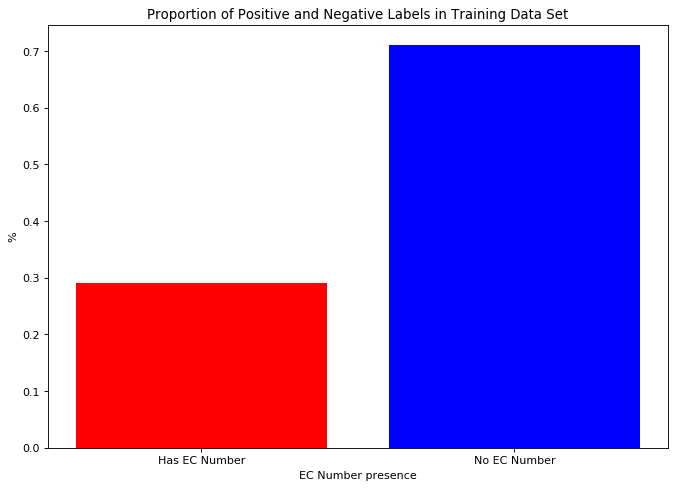

In [3]:
# Plot Proportion of Positive and Negative Labels in Training Data Set
left = [0, 1] 
height = [pos_pcent, neg_pcent] 
tick_label = ['Has EC Number', 'No EC Number']
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(left, height, tick_label = tick_label, width = 0.8, color = ['red', 'blue']) 
plt.xlabel('EC Number presence') 
plt.ylabel('%') 
plt.title('Proportion of Positive and Negative Labels in Training Data Set') 
plt.show() 

Looking at the training data set, we see that there are many examples of the "has no EC number" event (class 0) and few examples of the "has EC number" event (class 1). This means that there is an imbalance in the observations between the two classes. 

Knowing whether our data sets are imbalanced or not is useful, because when data sets are imbalanced with many negative events and few positive events, we will want to later analyze the performance of our models not just by looking at how well the models perform in general - we are we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives. It is therefore imperative that we include a metric in analysis that uses calculations that don't make use of true negatives, such as the precision and recall curve, which is only concerned with the correct prediction of the minority class, class 1.

In [4]:
# Get list of AAs 
vectorizer = TfidfVectorizer(token_pattern = r"(?u)\b\w+\b") # Tfid filters out strings of length < 2 by default
x_tr_tfid = vectorizer.fit_transform(x_tr)
AA_list = vectorizer.get_feature_names()
print("The following are the list of amino acids that make up proteins in the data set:\n %s\nThis matches our understanding and expectations of the amino acids that we should find in humans." % AA_list)

The following are the list of amino acids that make up proteins in the data set:
 ['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y']
This matches our understanding and expectations of the amino acids that we should find in humans.


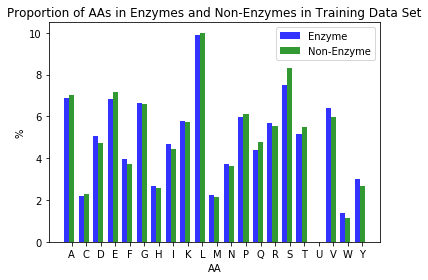

In [5]:
# Plot Proportion of AAs in Enzymes and Non-Enzymes in Training Data Set
pos_EC_AAs = ""
pos_EC_AA_lens = []
neg_EC_AAs = ""
neg_EC_AA_lens = []
for entry, EC_val in zip(x_tr, y_tr):
    if EC_val == 0:
        neg_EC_AAs += " " + entry
        neg_EC_AA_lens.append(len(entry))
    elif EC_val == 1:
        pos_EC_AAs += " " + entry
        pos_EC_AA_lens.append(len(entry))
pos_count = Counter(pos_EC_AAs.split())
pos_count = sorted([(i, pos_count[i] / len(pos_EC_AAs.split()) * 100.0) for i in pos_count])
neg_count = Counter(neg_EC_AAs.split())
neg_count = sorted([(i, neg_count[i] / len(neg_EC_AAs.split()) * 100.0) for i in neg_count])

fig, ax = plt.subplots()
labels, pos_values = map(list, zip(*pos_count))
labels, neg_values = map(list, zip(*neg_count))
index = np.arange(len(labels))
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, pos_values, bar_width, alpha=opacity, color='b', label='Enzyme')
rects2 = plt.bar(index + bar_width, neg_values, bar_width, alpha=opacity, color='g', label='Non-Enzyme')
plt.xlabel('AA') 
plt.ylabel('%') 
plt.title('Proportion of AAs in Enzymes and Non-Enzymes in Training Data Set') 
plt.xticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()


Comparing the % occurence of each AA in enzymes and non-enzymes in the training data set, it seems like there are no significant differents in % occurrence of AAs in enzymes and non-enzymes, perhaps other than S (serine) and Q (glutamine). It would appear then that any individual AA's % occurrence is unlikely to help indicate whether an AA sequence is an enzyme or not. The next hypothesis would be to explore whether neighborhoods in an AA sequence or neighborhoods in 3-dimensional structure contribute to the determination of whether an AA sequence is an enzyme or not. To explore and see if there are immediate patterns between AA sequence neighborhoods, one may want to use n-gram vectorizers.

1279.585288522511
1174.9321770644576


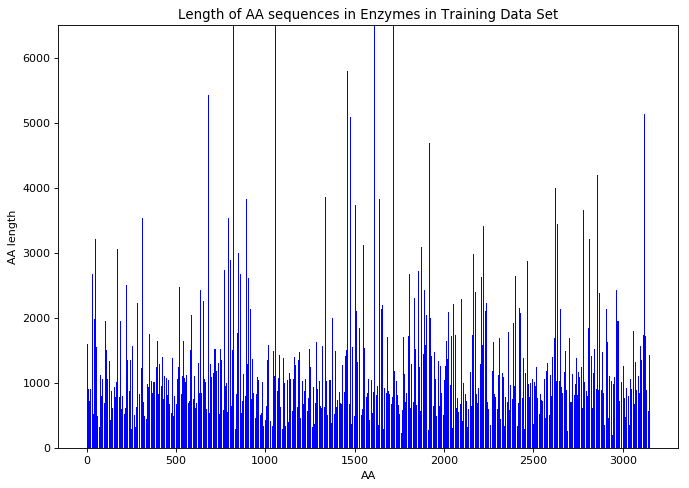

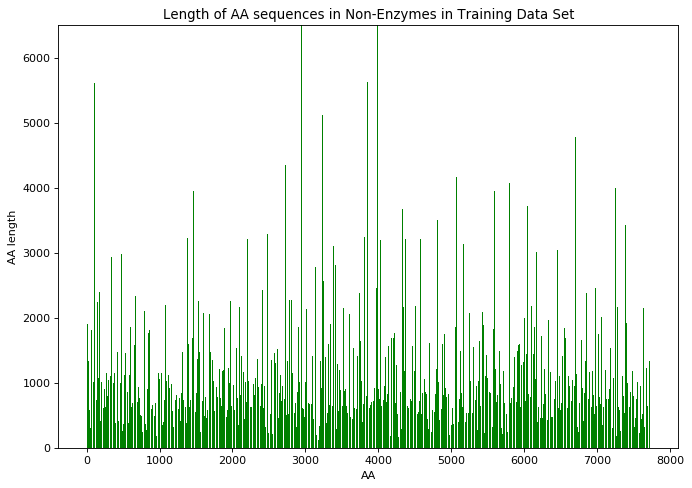

In [6]:
print(sum(pos_EC_AA_lens) / len(pos_EC_AA_lens))
print(sum(neg_EC_AA_lens) / len(neg_EC_AA_lens))

# Plot Length of AA sequences in Enzymes and Non-Enzymes in Training Data Set
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
x = np.arange(len(pos_EC_AA_lens))
plt.bar(x, height= pos_EC_AA_lens, color='b') 
plt.ylim([0, 6500])
plt.xlabel('AA') 
plt.ylabel('AA length') 
plt.title('Length of AA sequences in Enzymes in Training Data Set')
plt.show()

fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
x = np.arange(len(neg_EC_AA_lens))
plt.bar(x, height= neg_EC_AA_lens, color='g') 
plt.ylim([0, 6500])
plt.xlabel('AA') 
plt.ylabel('AA length') 
plt.title('Length of AA sequences in Non-Enzymes in Training Data Set')
plt.show()

Comparing the length of individual AA sequences in enzymes and non-enzymes in the training set, it seems that AA sequences of length > 3500 will mostly be enzymes. In addition, on average, enzymes' AA sequence length tends to be longer than that of non-enzymes. However, the distinction of enzymes vs. non-enzymes is not particularly strong using AA sequence length alone.

## Hyperparameter Tuning and Training

In [7]:
"""
Hyperparameter tuning pipeline.
"""
pipe, parameters, yhat1_tr, yhat1_te = ad.tune(cv_num, x_tr, y_tr, x_te)

/Users/remmyc12106937/miniconda3/envs/csb_env/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/remmyc12106937/miniconda3/envs/csb_env/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/remmyc12106937/miniconda3/envs/csb_env/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/remmyc12106937/miniconda3/envs/csb_env/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/remmyc12106937/miniconda3/envs/csb_env/lib/python3.6/site-packages/sklearn/naive_bayes.py:480

In [11]:
# Print accuracy of training set and confusion matrix
thresh = 0.5
accuracy = np.mean(y_tr == (yhat1_tr >= thresh))
print(accuracy)
cm = sklearn.metrics.confusion_matrix(y_tr, yhat1_tr >= thresh)
cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
print(cm_df)

1.0
Predicted     0     1
True                 
0          7726     0
1             0  3154


In [12]:
# Print accuracy of test set and confusion matrix
thresh = 0.5
accuracy = np.mean(y_te == (yhat1_te >= thresh))
print(accuracy)
cm = sklearn.metrics.confusion_matrix(y_te, yhat1_te >= thresh)
cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
print(cm_df)

0.8650735294117647
Predicted     0    1
True                
0          1920   28
1           339  433


The training set perfectly predicted all the AA sequences, suggesting that perhaps the model has high variance and is overfitting to the training set. On a hold-out fold, the model has an accuracy of 0.8457720588235295. Interestingly, the model has much more false negatives than false positives in the test set, meaning that the model is more likely to misclassify an enzyme as a non-enzyme than to misclassify a non-enzyme as an enzyme.

## Data Analysis

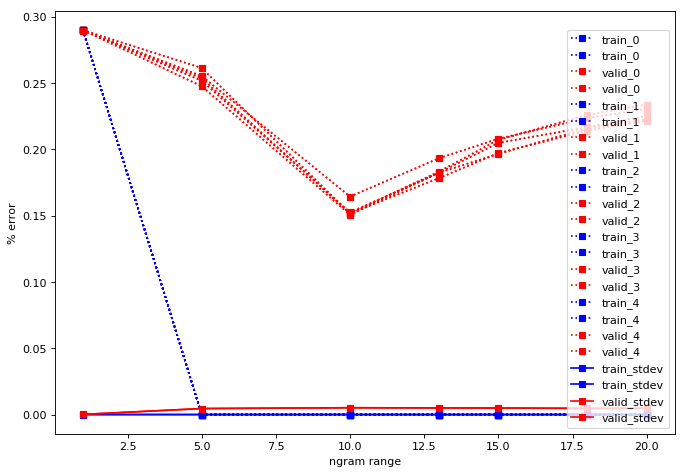

In [13]:
"""
Error analysis.
"""
hyper = 'tfidf__ngram_range'
fold_train_err_list, fold_test_err_list, std_train_list, std_test_list = ad.err_analyze(pipe, parameters, hyper, cv_num)

fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel('ngram range')
plt.ylabel('% error')
for i in range(cv_num):
    plt.plot(parameters[hyper], fold_train_err_list[i], 'bs:', label='train_'+str(i))
    plt.plot(parameters[hyper], fold_test_err_list[i], 'rs:', label='valid_'+str(i))
plt.plot(parameters[hyper], std_train_list, 'bs-', label='train_stdev')
plt.plot(parameters[hyper], std_test_list, 'rs-', label='valid_stdev')
plt.legend(loc='lower right')

The graph above plotting ngram range against error shows that validation error of different folds has a wider range of error levels compared to training error of different folds, which generally perform at approximate levels. This observation is captured by the standard deviation, which suggests less generalizable performance for the validation set than for the training set. The validation error across different values of ngram_range is much greater than training error, suggesting high variance and overfitting. Interestingly, training error drops to 0 at most ngram_range values, which seems rather bizarre.

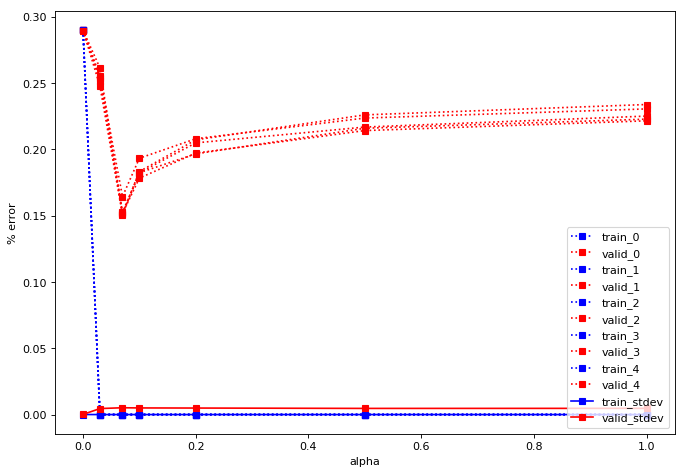

In [14]:
"""
Error analysis.
"""
hyper = 'multi_nb__alpha'
fold_train_err_list, fold_test_err_list, std_train_list, std_test_list = ad.err_analyze(pipe, parameters, hyper, cv_num)

fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel('alpha')
plt.ylabel('% error')
for i in range(cv_num):
    plt.plot(parameters[hyper], fold_train_err_list[i], 'bs:', label='train_'+str(i))
    plt.plot(parameters[hyper], fold_test_err_list[i], 'rs:', label='valid_'+str(i))
plt.plot(parameters[hyper], std_train_list, 'bs-', label='train_stdev')
plt.plot(parameters[hyper], std_test_list, 'rs-', label='valid_stdev')
plt.legend(loc='lower right')


The graph above plotting alpha against error shows that validation error of different folds has a wider range of error levels compared to training error of different folds, which generally perform at approximate levels. This observation is captured by the standard deviation, which suggests less generalizable performance for the validation set than for the training set. The validation error across different values of alpha is much greater than training error, suggesting high variance and overfitting. Interestingly, training error drops to 0 at most alpha values, which seems rather bizarre.

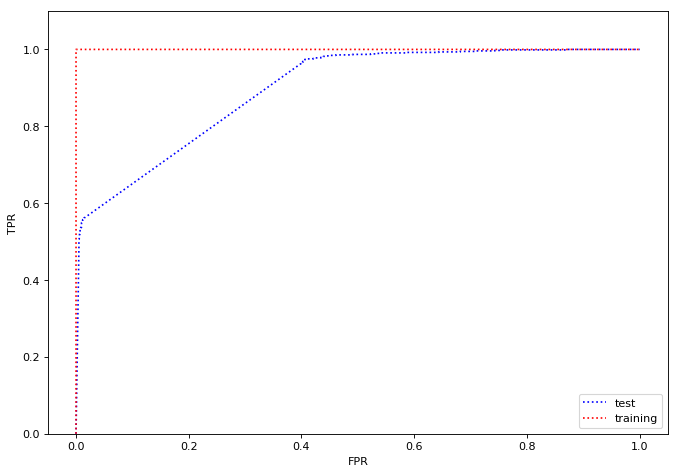

In [15]:
# ROC curve
fpr_te, tpr_te, thr_te = sklearn.metrics.roc_curve(y_te, yhat1_te)
fpr_tr, tpr_tr, thr_tr = sklearn.metrics.roc_curve(y_tr, yhat1_tr)
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim([0, 1.1]);
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.plot(fpr_te, tpr_te, 'b:', label='test')
plt.plot(fpr_tr, tpr_tr, 'r:', label='training')
plt.legend(loc='lower right')

In terms of ROC performance, the ROC curve for the training set is perfect and as good as it can be, whereas the ROC curve for the test set, which does not go steeper along the y axis and then go along the x axis, has worse performance. It would have been useful to plot the ROC curve for each held-out set during training using k-fold CV instead of for the overall training set, but there isn't any good way to do so.

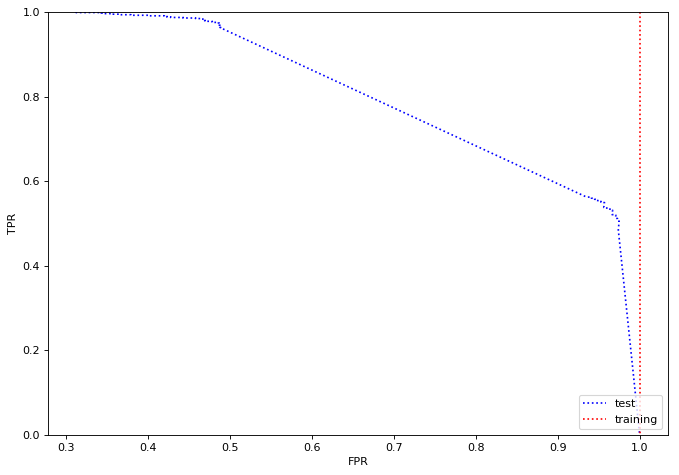

In [16]:
# Precision-Recall Curve
prec_te, recall_te, thr_te = sklearn.metrics.precision_recall_curve(y_te, yhat1_te)
prec_tr, recall_tr, thr_tr = sklearn.metrics.precision_recall_curve(y_tr, yhat1_tr)
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim([0, 1]);
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.plot(prec_te, recall_te, 'b:', label='test')
plt.plot(prec_tr, recall_tr, 'r:', label='training')
plt.legend(loc='lower right')

In terms of PR performance, again the PR curve of the training set outperforms the PR curve of the test set. It would have been useful to plot the PR curve for each held-out set during training using k-fold CV instead of for the overall training set, but there isn't any good way to do so.

## Discussion

The best combination of hyperparameters is {'multi_nb__alpha': 0, 'tfidf__ngram_range': (10, 10)}, with an accuracy of 0.8650735294117647 using the test set.

In literature, there is one paper by Naik, et al. published in 2007 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2248448/) that uses ANN to solve the same classification problem. The study uses 61 amino acid sequence-derived parameters such as AA sequence molecular weight and AA sequence isoelectric point to make classifications, whereas I use tokenized amino acid sequences alone to make classifications. The study shows that their ANN model achieves a 79% prediction accuracy score of enzymes vs. non-enzymes. Another paper by Sharif, et al. published in 2016 (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7813731&tag=1) uses PCA and Adaboost classifier to solve this problem. The study uses 800 AA sequences and achieves a 87% prediction accuracy score.

The prediction accuracy score reported in this project, which is around 86.5% on a test set of 2720 AA sequences found in humans, is higher than the Naik, et al. paper and approximate to the Sharif, et al. Perhaps the reason this model achieves better performance than the Naik, et al. paper is in part due to a bigger training set of 10881 AA sequences and test set of 2720 AA sequences used in this project, whereas the Naik, et al. paper seems to have only used 660 AA sequences for both training and testing via cross validation. It's delightful to learn that the model used here achieves similarly high performance compared to papers in the wild, such as the Sharif, et al. paper, particularly when done using a different approach.

For more analysis of performance, it would be necessary for all the models to predict on the same unseen test set and for more standardization to take place, so that cross-literature comparisons may be better made.

Regardless, the fairly high performance of the model in this project suggests that immediate neighborhoods in an AA sequence contribute quite highly to the classification of AA sequences as enzymes or non-enzymes. 

For reference, one run of data scraping (by running retrieve_data.py) takes many, many hours to run on a personal computer, with the bottleneck being API requests to the KEGG database. One run of tuning the model to find the best hyperparameter values and training the model (by running this jupyter notebook or running analyze_data.py) take approximately 4 hours to run on a personal computer.

## Future Work

A possible future direction is to impove the model's accuracy, such as by trying a wider range of hyperparameter values, hyperparameters and classifiers where time permits and by adding additional AA-derived features such as AA sequence length to the feature set. Notably, the current model highly overfits to the training set, so measures such as regularization should be introduced to reduce complexity and lower variance. In addition to improving the current model's accuracy, it would be interesting to see whether and how much 3D neighborhoords contribute to enzyme vs. non-enzyme classification, as compared to AA sequence neighborhoods. 3D neighborhoods are harder to determine because the identification of neighborhoods involves knowledge of protein folding, but is possible.

## Acknowledgements

Thank you to peers in my Computational Systems Biology course for fruitful discussions throughout the semester and to the teaching staff in both the Computational Systems Biology course for guidance and instruction and the Introduction to Machine Learning course for teaching me machine learning skills, which I used heavily to apply to this problem.

## Supplementary Data

In [9]:
# Print hyperparameter values tried
print(parameters)

{'tfidf__ngram_range': [(1, 1), (5, 5), (10, 10), (13, 13), (15, 15), (18, 18), (20, 20)], 'multi_nb__alpha': [0, 0.03, 0.07, 0.1, 0.2, 0.5, 1]}


In [10]:
# Print best hyperparameter values, best test score, and CV results of training set
print(pipe.best_params_)
print(pipe.best_score_)
print(pipe.cv_results_)

{'multi_nb__alpha': 0, 'tfidf__ngram_range': (10, 10)}
0.8457720588235295
{'mean_fit_time': array([10.59116125, 32.78240705, 52.26324868, 52.9275053 , 53.06590295,
       53.95525732, 58.95386629, 11.21375551, 34.95143118, 56.41989369,
       57.05845017, 57.39228878, 58.41762586, 58.52118177, 11.23362675,
       34.28383226, 56.35039878, 56.9595993 , 56.99321918, 58.28317766,
       58.47559137, 10.67944961, 34.14127779, 56.5729732 , 56.851265  ,
       57.29046435, 58.43961263, 58.13614793, 10.91556487, 34.94037256,
       56.32432871, 57.01311202, 57.12164078, 58.45829983, 58.40953894,
       10.94969501, 34.57575412, 56.17944779, 56.93839798, 57.09035454,
       58.25287619, 58.44648991, 11.13860011, 34.41338534, 56.20067062,
       56.99680576, 57.05316682, 58.23439589, 58.68590121]), 'std_fit_time': array([0.3356425 , 0.20912156, 0.48716364, 0.4529576 , 0.38920334,
       0.23837938, 0.46639639, 0.24020634, 0.19975751, 0.37288055,
       0.268997  , 0.25307721, 0.54257587, 0.3298

In [8]:
# Save data used again
np.savetxt('x_train.txt', x_tr, fmt='%s')
np.savetxt('y_train.txt', y_tr)
np.savetxt('yproba1_train.txt', yhat1_tr)
np.savetxt('x_test.txt', x_te, fmt='%s')
np.savetxt('y_test.txt', y_te)
np.savetxt('yproba1_test.txt', yhat1_te)